load libraries

In [1]:
import cv2
from keras.models import *
from keras.layers import *
from keras.applications import *
from keras.preprocessing.image import *

Using TensorFlow backend.


# 加载数据集

猫狗大战：https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition

In [2]:
import numpy as np
from tqdm import tqdm

np.random.seed(2017)
model_image_size = 224

n = 25000
X = np.zeros((n, model_image_size, model_image_size, 3), dtype=np.uint8)
y = np.zeros((n, 1), dtype=np.uint8)

for i in tqdm(range(n//2)):
    image = cv2.imread( "data0/train/cats/cat.%d.jpg" % i)
    X[i] = cv2.resize(image, (model_image_size, model_image_size))
    image = cv2.imread('data0/train/dogs/dog.%d.jpg' % i)
    X[i+n//2] = cv2.resize(image, (model_image_size, model_image_size))

y[n//2:] = 1

100%|██████████| 12500/12500 [00:38<00:00, 322.93it/s]


# 分为训练集和验证集

In [3]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)

print(len(X_train))
print(len(X_valid))

20000
5000


# 构建模型

https://github.com/fchollet/keras/blob/master/keras/applications/resnet50.py


In [4]:
base_model = VGG19(input_tensor=Input((model_image_size, model_image_size, 3)), weights='imagenet', include_top=False)

for layers in base_model.layers:
    layers.trainable = False

x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.25)(x)
x = Dense(1, activation='sigmoid')(x)
model = Model(base_model.input, x)
print("done")

done


In [5]:
model.compile(optimizer='adadelta',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()
print("done")

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

# 训练模型

In [6]:
model.fit(X_train, y_train, batch_size=16, epochs=5, validation_data=(X_valid, y_valid))

model.save("models/vgg19-mymodel.h5")

Train on 20000 samples, validate on 5000 samples
Epoch 1/5
20000/20000 [==============================] - 114s - loss: 0.6945 - acc: 0.8591 - val_loss: 0.1152 - val_acc: 0.9636

# 可视化模型

https://keras.io/visualization/

load successed


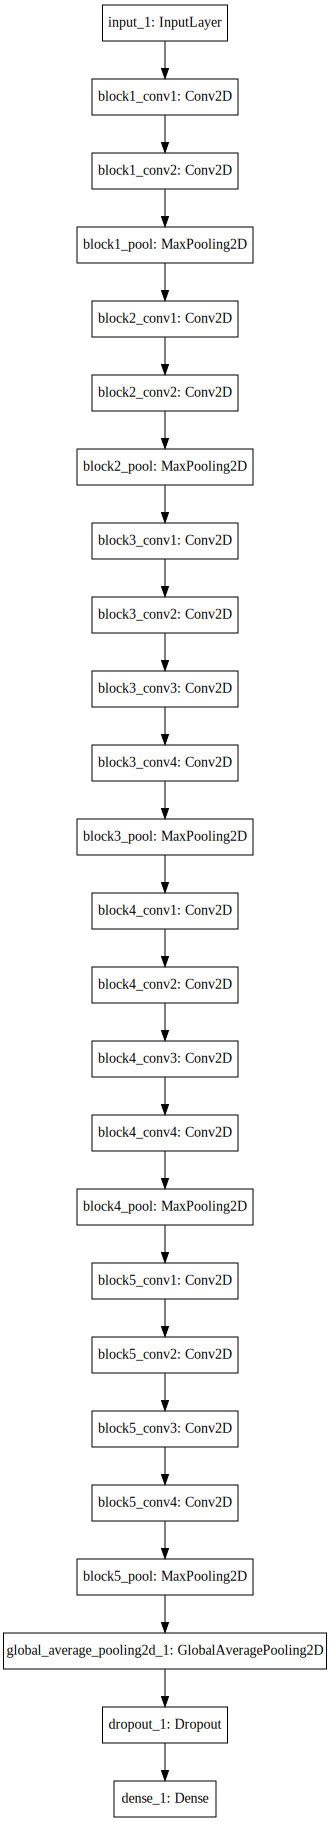

In [7]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.models import *

model = load_model("models/vgg19-mymodel.h5")
print("load successed")

SVG(model_to_dot(model).create(prog='dot', format='svg'))

# CAM 可视化

http://cnnlocalization.csail.mit.edu/

![](http://cnnlocalization.csail.mit.edu/framework.jpg)

$cam = (P-0.5)*w*output$

* cam: 类激活图 7\*7
* P: 猫狗概率
* output: 卷积层的输出 2048\*1
* w: 卷积核的权重 7\*7\*2048

In [8]:
z = zip([x.name for x in model.layers], range(len(model.layers)))
for k, v in z:
    print("{} - {}".format(k,v))

input_1 - 0
block1_conv1 - 1
block1_conv2 - 2
block1_pool - 3
block2_conv1 - 4
block2_conv2 - 5
block2_pool - 6
block3_conv1 - 7
block3_conv2 - 8
block3_conv3 - 9
block3_conv4 - 10
block3_pool - 11
block4_conv1 - 12
block4_conv2 - 13
block4_conv3 - 14
block4_conv4 - 15
block4_pool - 16
block5_conv1 - 17
block5_conv2 - 18
block5_conv3 - 19
block5_conv4 - 20
block5_pool - 21
global_average_pooling2d_1 - 22
dropout_1 - 23
dense_1 - 24


http://docs.opencv.org/trunk/d3/d50/group__imgproc__colormap.html

![](http://docs.opencv.org/trunk/colorscale_jet.jpg)

In [9]:
import matplotlib.pyplot as plt
import random
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

def show_heatmap_image(model_show, weights_show):
    plt.figure(figsize=(12, 14))
    for i in range(16):
        plt.subplot(4, 4, i+1)
        img = cv2.imread('data0/test/test1/%d.jpg' % (100*i + 31))
        img = cv2.resize(img, (model_image_size, model_image_size))
        x = img.copy()
        x.astype(np.float32)
        out, prediction = model_show.predict(np.expand_dims(x, axis=0))

        prediction = prediction[0]
        out = out[0]

        if prediction < 0.5:
            plt.title('cat %.2f%%' % (100 - prediction*100))
        else:
            plt.title('dog %.2f%%' % (prediction*100))

        cam = (prediction - 0.5) * np.matmul(out, weights_show)
        cam -= cam.min()
        cam /= cam.max()
        cam -= 0.2
        cam /= 0.8

        cam = cv2.resize(cam, (model_image_size, model_image_size))
        heatmap = cv2.applyColorMap(np.uint8(255*cam), cv2.COLORMAP_JET)
        heatmap[np.where(cam <= 0.2)] = 0

        out = cv2.addWeighted(img, 0.8, heatmap, 0.4, 0)

        plt.axis('off')
        plt.imshow(out[:,:,::-1])
print("done")

done


layer_output Tensor("block5_pool_1/MaxPool:0", shape=(?, 7, 7, 512), dtype=float32)
weights shape (512, 1)


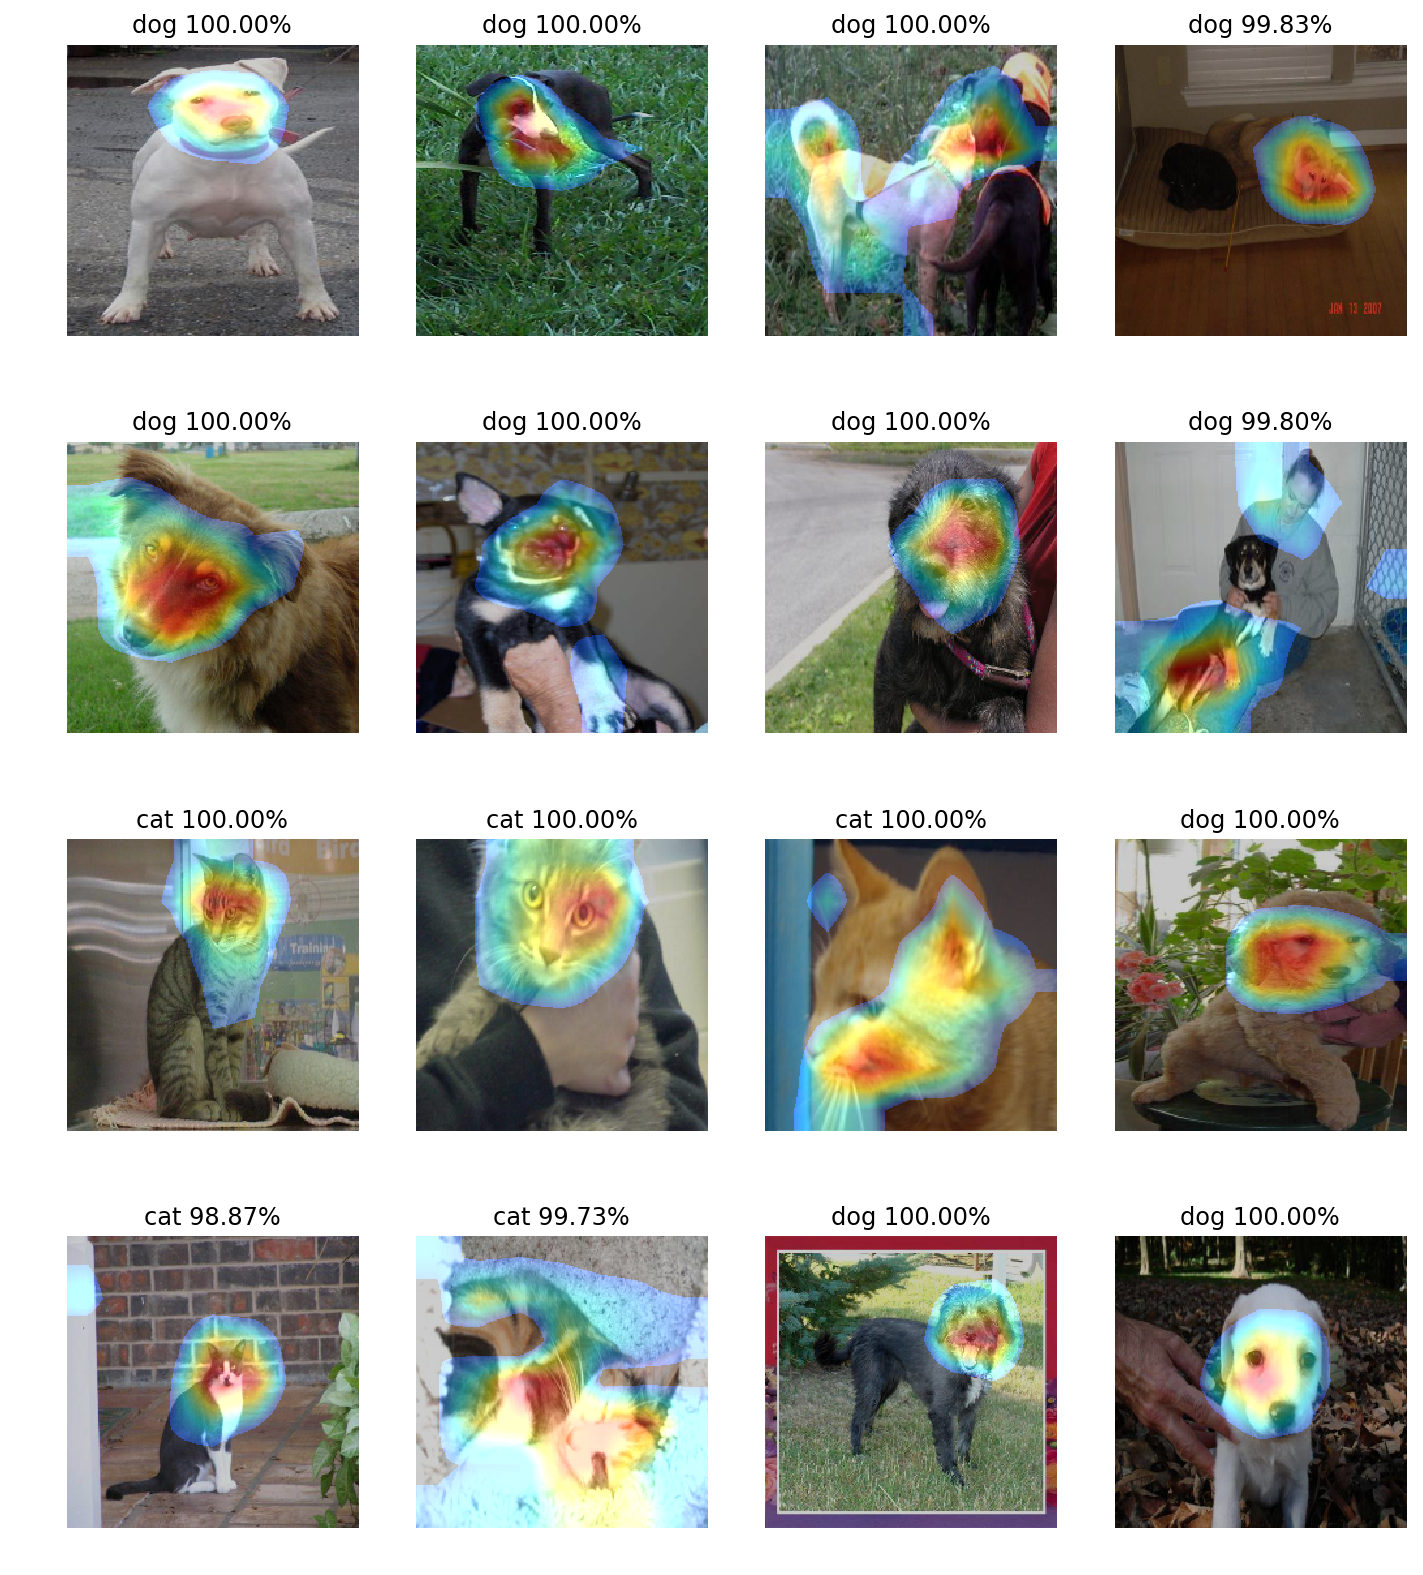

In [12]:
weights = model.layers[24].get_weights()[0]
layer_output = model.layers[21].output
model2 = Model(model.input, [layer_output, model.output])
print("layer_output {0}".format(layer_output))
print("weights shape {0}".format(weights.shape))
show_heatmap_image(model2, weights)

layer_output Tensor("block5_conv4_1/Relu:0", shape=(?, 14, 14, 512), dtype=float32)
weights shape (512, 1)


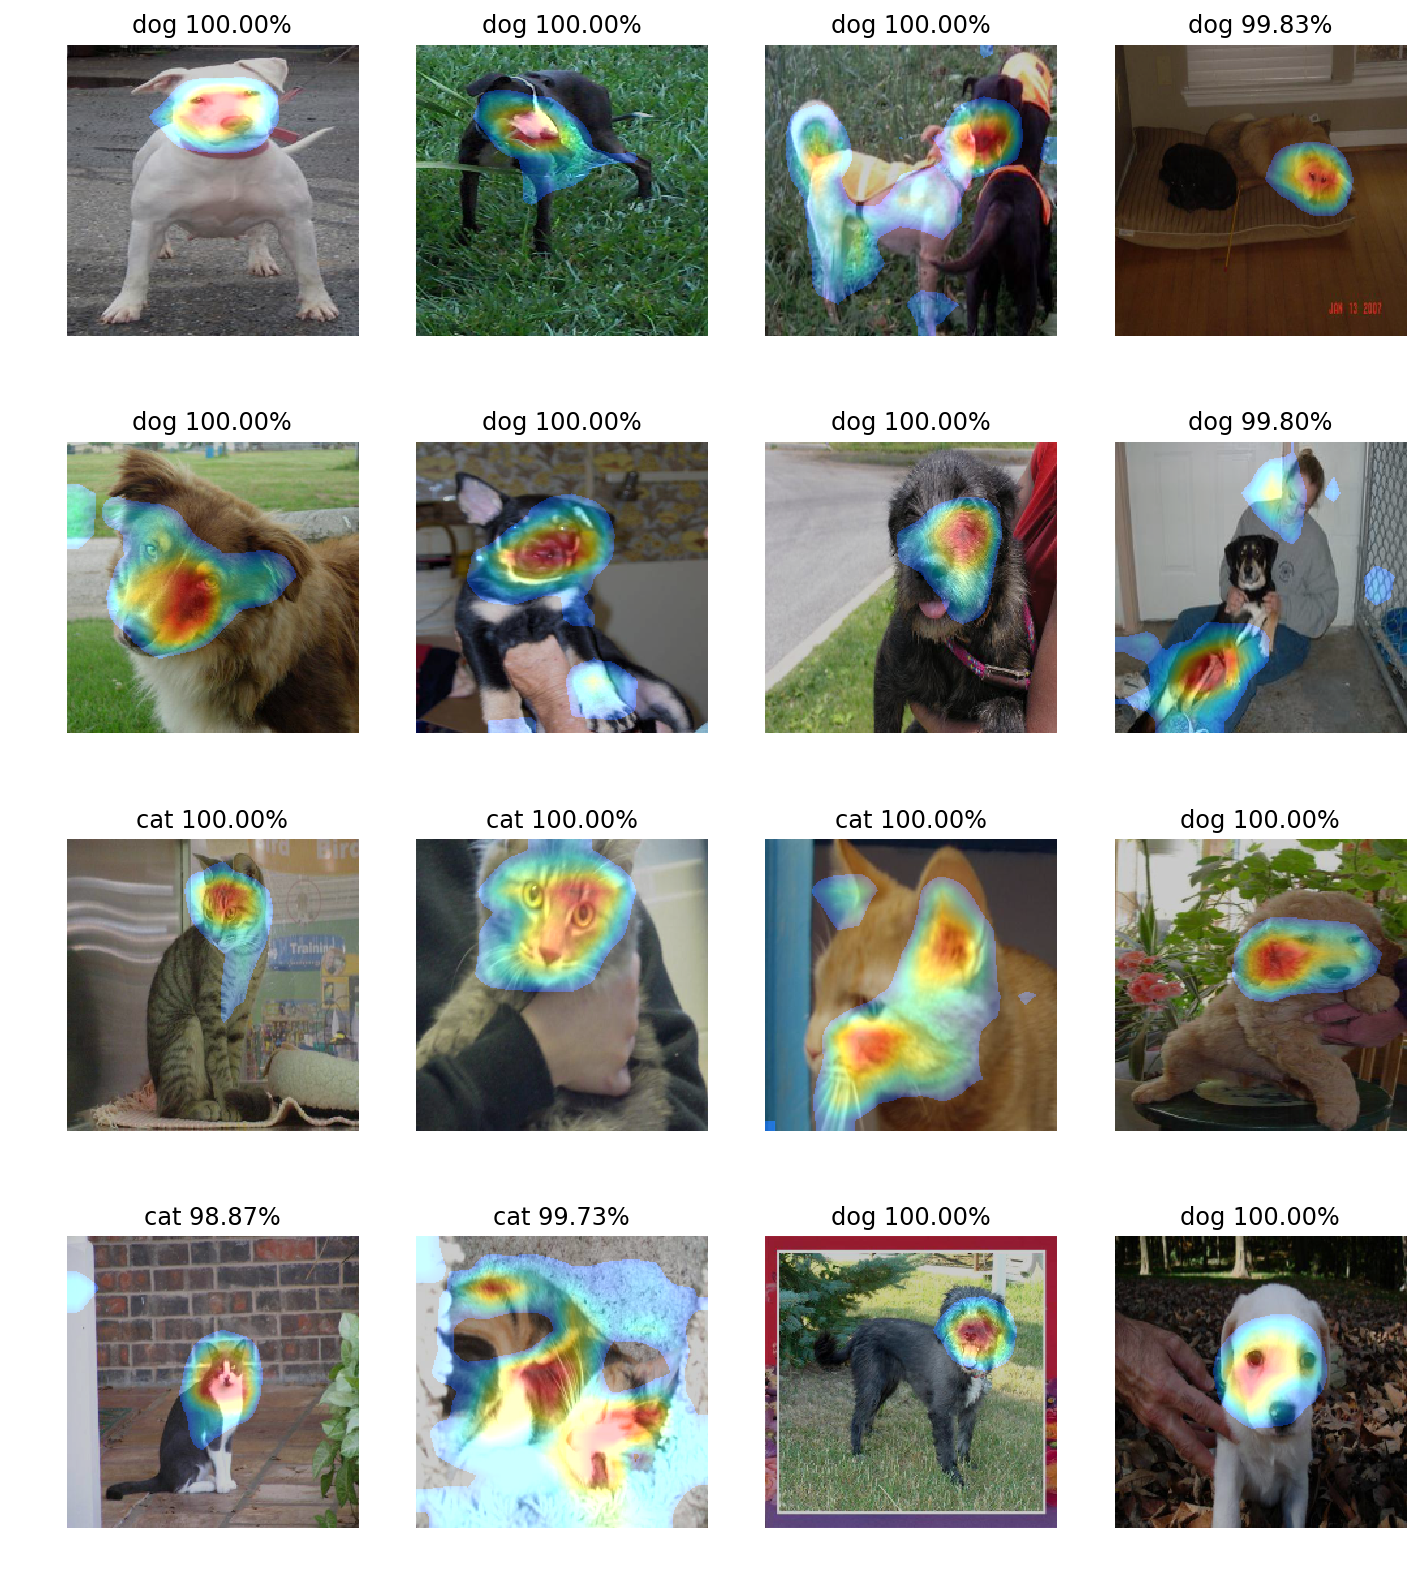

In [14]:
weights = model.layers[24].get_weights()[0]
layer_output = model.layers[20].output
model2 = Model(model.input, [layer_output, model.output])
print("layer_output {0}".format(layer_output))
print("weights shape {0}".format(weights.shape))
show_heatmap_image(model2, weights)

layer_output Tensor("block5_conv3_1/Relu:0", shape=(?, 14, 14, 512), dtype=float32)
weights shape (512, 1)


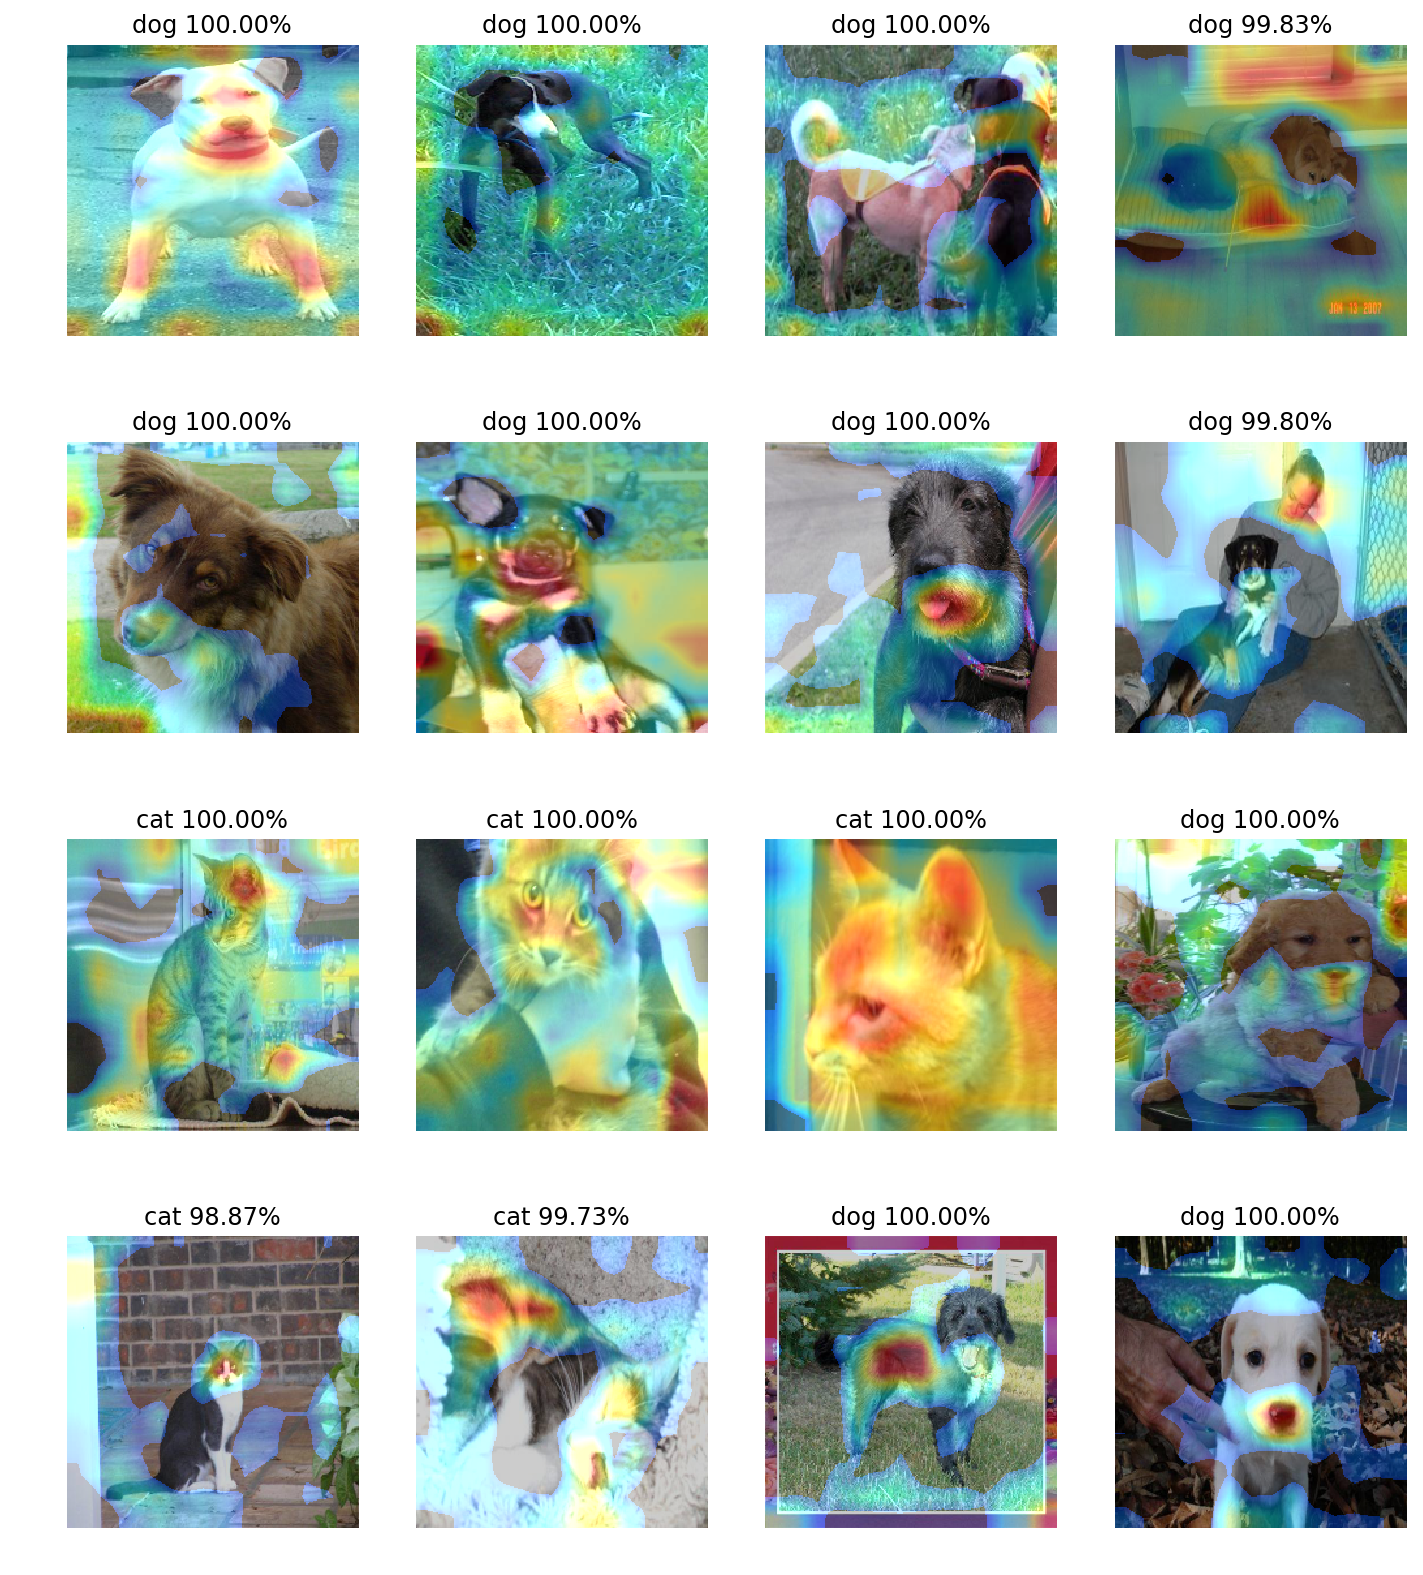

In [15]:
weights = model.layers[24].get_weights()[0]
layer_output = model.layers[19].output
model2 = Model(model.input, [layer_output, model.output])
print("layer_output {0}".format(layer_output))
print("weights shape {0}".format(weights.shape))
show_heatmap_image(model2, weights)